# Shoreline Forecasting Data Analysis Example

In [1]:
import pandas as pd

from datetime import datetime

from preprocessing.helpers import (
    str2int,
    optimize,
    unnesting,
    pivot_tsdf,
    format_tsdf,
    add_geometry,
    interpolate_nans,
    split_metadata_tsdf,
    drop_non_tokenizable,
    create_tokenized_tsdf,
    drop_empty_geometries,
    save_preprocessed_data,
    load_preprocessed_data

)
from preprocessing.filters import (
    filter_tsdf_by_nans,
    get_metadata_filter,
    filter_tsdf_by_metadata
)
from models.helpers import (
    pt2df,
    configure_torch,
    get_lstm_configs,
    get_scaled_splits,
    evaluate_performance,
    get_torch_dataloaders
)
from models.lstm import (
    Net,
    train_model,
    inference_model
)
from visualization.plots import plot_forecast
from utils.configs import get_yaml_configs
from utils.logger import get_logger
    


### Configurations
Configurations are loaded from the ```configurations/default.yml``` file. 

In [2]:
configs = get_yaml_configs()

### Logger
Initialize a logger object to keep track of data statistics. 

In [3]:
logger = get_logger(configs)
logger.critical(f"Configs: {configs.items()}")

### Load data
Data is loaded from this [AWS S3 Cloud Storage bucket]("https://s3.eu-central-1.amazonaws.com/floris.calkoen.open.data/outliers.csv"). 

We will load a csv (sample_data.csv) containing all satellite-derived shoreline position data. This data includes both metadata about the sites and the shoreline positions. 

Alternatively cleaned metadata (sites.csv) and time series (time-series.csv) dataframes can be loaded directly. For demonstration purposes we here continue with the raw sample data.   

In [4]:
data = pd.read_csv(configs['data']['data_url'])
data

,transect_id,country_id,continent,country_name,changerate,changerate_unc,flag_sandy,no_shorelines,dt,dist,...,low_detect_shlines,err_changerate,err_timespan,Start_lon,Start_lat,Intersect_lon,Intersect_lat,End_lon,End_lat,coastline_idint
0,BOX_171_060_0,CHN,Asia,China,0.589744,0.334699,True,25.0,"[8.00016427442, 9.00223823898, 10.0015742965, ...","[215.1869647438905, 251.30979024553088, 242.66...",...,1.0,1.0,1.0,117.900417,38.240886,117.903021,38.247638,117.905626,38.254390,24527.0
1,BOX_210_183_289,FIN,Europe,Finland,0.335331,0.215781,False,26.0,"[1.00207396456, 2.00141002211, 3.00074607966, ...","[401.74341950917534, 399.38580911126127, 380.1...",...,1.0,1.0,1.0,25.874430,60.232761,25.865837,60.234061,25.857245,60.235361,18980.0
2,BOX_160_105_189,USA,North America,United States of America,-3.624761,0.156524,False,33.0,"[0.0, 1.00207396456, 2.00141002211, 3.00074607...","[576.0500543019966, 559.5215270803751, 578.265...",...,1.0,1.0,1.0,-76.238579,38.622444,-76.246065,38.626322,-76.253552,38.630201,7631.0
3,BOX_104_149_109,IDN,Asia,Indonesia,1.195667,0.676119,False,28.0,"[4.00008213721, 5.00215610177, 6.00149215932, ...","[1162.9250684950227, 1342.868597128692, 1182.9...",...,1.0,1.0,1.0,106.775059,-2.919350,106.770364,-2.911701,106.765670,-2.904052,23716.0
4,BOX_050_187_223,CHL,South America,Chile,0.586577,0.165336,False,24.0,"[1.00207396456, 2.00141002211, 3.00074607966, ...","[858.4598088473394, 865.0618254583263, 857.172...",...,1.0,1.0,1.0,-73.204270,-41.755902,-73.196734,-41.752254,-73.189199,-41.748606,5432.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,BOX_179_092_257,CAN,North America,Canada,0.132980,0.032875,False,33.0,"[0.0, 1.00207396456, 2.00141002211, 3.00074607...","[714.9960548891196, 719.1543695372774, 718.787...",...,1.0,1.0,1.0,-127.147190,51.061587,-127.144571,51.056186,-127.141951,51.050785,1926.0
996,BOX_210_098_52,EST,Europe,Estonia,-0.151449,0.165423,False,29.0,"[0.0, 1.00207396456, 2.00141002211, 3.00074607...","[728.2766908825778, 727.3618516533627, 728.904...",...,1.0,1.0,1.0,23.760790,58.341734,23.757195,58.337412,23.753600,58.333091,16820.0
997,BOX_187_483_173,SWE,Europe,Sweden,0.459964,0.125180,False,27.0,"[0.0, 1.00207396456, 2.00141002211, 3.00074607...","[475.9482621354429, 469.68954901197156, 468.99...",...,1.0,1.0,1.0,11.601994,57.785843,11.610236,57.787748,11.618478,57.789652,20075.0
998,BOX_186_430_30,GBR,Europe,United Kingdom,-0.065584,0.222241,False,25.0,"[0.0, 1.00207396456, 2.00141002211, 3.00074607...","[976.8413624443741, 996.9434728104769, 987.021...",...,1.0,1.0,1.0,-6.335992,57.243104,-6.344961,57.242838,-6.353931,57.242572,15269.0


Finally we also load a file (outliers.csv) containing information about outliers which were detected by Luijendijk et al. (2018) and later by Kras (2019). The outlier indices are nested in the csv. We therefore first have to explode the dataframe.

In [5]:
outliers = pd.read_csv(configs['data']['outliers_url'])
outliers['outliers_1'] = outliers['outliers_1'].apply(str2int)
outliers['outliers_2'] = outliers['outliers_2'].apply(str2int)
outliers

,transect_id,outliers_1,outliers_2
0,BOX_028_183_29,"[5, 6, 9, 10, 11, 12, 13, 14]",[]
1,BOX_028_045_318,"[2, 5, 6, 12, 15]",[10]
2,BOX_028_237_30,"[0, 1, 2]",[]
3,BOX_028_318_9,"[1, 16]",[4]
4,BOX_028_099_49,[],[]
...,...,...,...
963,BOX_210_080_172,[],[19]
964,BOX_210_080_454,[],[]
965,BOX_210_075_15,"[3, 10, 13, 14]",[]
966,BOX_211_032_5,[],[]


### Preprocessing
First we optimize the dtypes of the dataframe to reduce its size. 

In [6]:
data = optimize(data, ignore_features = ['dt', 'dist', 'outliers_1', 'outliers_2'])

Now we will seperate the time-serise data and metadata. First we create a tokenized version of the dataframe; we split the shoreline positions (distance) and dates (dt) from one string into floats. We also drop the non-tokenizable strings; the sites without observations. Finally we seperate the data into two dataframes: time series and metadata. 

In [7]:
data = create_tokenized_tsdf(data)
data = drop_non_tokenizable(data)
metadata, tsdf = split_metadata_tsdf(data)

/home/floris/anaconda3/envs/ds-thesis/lib/python3.7/site-packages/tqdm/std.py:666: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


ValueError: could not convert string to float:  most likely the string is empty.
ValueError: could not convert string to float:  most likely the string is empty.
ValueError: could not convert string to float:  most likely the string is empty.
ValueError: could not convert string to float:  most likely the string is empty.
ValueError: could not convert string to float:  most likely the string is empty.
ValueError: could not convert string to float:  most likely the string is empty.
ValueError: could not convert string to float:  most likely the string is empty.
ValueError: could not convert string to float:  most likely the string is empty.
ValueError: could not convert string to float:  most likely the string is empty.
ValueError: could not convert string to float:  most likely the string is empty.
ValueError: could not convert string to float:  most likely the string is empty.
ValueError: could not convert string to float:  most likely the string is empty.
ValueError: could not conver

ValueError: could not convert string to float:  most likely the string is empty.
ValueError: could not convert string to float:  most likely the string is empty.
ValueError: could not convert string to float:  most likely the string is empty.
ValueError: could not convert string to float:  most likely the string is empty.
ValueError: could not convert string to float:  most likely the string is empty.
ValueError: could not convert string to float:  most likely the string is empty.
ValueError: could not convert string to float:  most likely the string is empty.
ValueError: could not convert string to float:  most likely the string is empty.
ValueError: could not convert string to float:  most likely the string is empty.
ValueError: could not convert string to float:  most likely the string is empty.
ValueError: could not convert string to float:  most likely the string is empty.
ValueError: could not convert string to float:  most likely the string is empty.
ValueError: could not conver

Above we can see that the time series data is now saved in an array. However, both the dates and shoreline positions are still kept in nested data structures. Furthermore, the dates are still expressed in decimals. Here we will unnest the dataframe and change the decimals to datetime objects. 

In [8]:
tsdf = unnesting(tsdf, explode=['dt', 'dist'])
tsdf = format_tsdf(tsdf)

In [9]:
metadata

,transect_id,country_id,continent,country_name,changerate,changerate_unc,flag_sandy,no_shorelines,RMSE,outliers_1,...,low_detect_shlines,err_changerate,err_timespan,Start_lon,Start_lat,Intersect_lon,Intersect_lat,End_lon,End_lat,coastline_idint
0,BOX_171_060_0,CHN,Asia,China,0.589744,0.334699,True,25.0,11.512436,[15],...,1.0,1.0,1.0,117.900414,38.240887,117.903023,38.247639,117.905624,38.254391,24527.0
1,BOX_210_183_289,FIN,Europe,Finland,0.335331,0.215781,False,26.0,10.111870,[],...,1.0,1.0,1.0,25.874430,60.232761,25.865837,60.234062,25.857244,60.235363,18980.0
2,BOX_160_105_189,USA,North America,United States of America,-3.624761,0.156524,False,33.0,8.298373,[],...,1.0,1.0,1.0,-76.238579,38.622444,-76.246063,38.626324,-76.253555,38.630199,7631.0
3,BOX_104_149_109,IDN,Asia,Indonesia,1.195667,0.676119,False,28.0,26.807337,[1],...,1.0,1.0,1.0,106.775055,-2.919350,106.770363,-2.911701,106.765671,-2.904052,23716.0
4,BOX_050_187_223,CHL,South America,Chile,0.586577,0.165336,False,24.0,7.306631,[],...,1.0,1.0,1.0,-73.204269,-41.755901,-73.196732,-41.752254,-73.189201,-41.748604,5432.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,BOX_179_092_257,CAN,North America,Canada,0.132980,0.032875,False,33.0,1.739944,[],...,1.0,1.0,1.0,-127.147194,51.061588,-127.144569,51.056187,-127.141953,51.050785,1926.0
996,BOX_210_098_52,EST,Europe,Estonia,-0.151449,0.165423,False,29.0,8.098720,[],...,1.0,1.0,1.0,23.760790,58.341732,23.757195,58.337414,23.753601,58.333092,16820.0
997,BOX_187_483_173,SWE,Europe,Sweden,0.459964,0.125180,False,27.0,6.184489,[],...,1.0,1.0,1.0,11.601994,57.785843,11.610236,57.787746,11.618478,57.789654,20075.0
998,BOX_186_430_30,GBR,Europe,United Kingdom,-0.065584,0.222241,False,25.0,10.050299,"[14, 22]",...,1.0,1.0,1.0,-6.335992,57.243103,-6.344961,57.242840,-6.353931,57.242573,15269.0


Since we are working with geospatial data, we will now convert the Pandas DataFrame to a GeoPandas DataFrame. Such dataframe with also include a geometry column. Meanwhile we will drop all sites without coordinates. 

In [10]:
metadata = add_geometry(metadata)
metadata = drop_empty_geometries(metadata)

### Filter by metadata
Here we filter the data according to configurations set in the configurations- (here default.yml) file. First we create a list of the transects we want to include into the analysis based on criteria such as whether the beach is sandy; or if the sediment is composited. We use this filter to get an updated time-series dataframe. We will furthermore drop both outliers 1 and 2 according to the outliers information provided in the file outliers.csv 

Finally we will pivot the dataframe so that each of the columns describe shoreline evolution of one of the transects. 

In [11]:
metadata_filter = get_metadata_filter(metadata, tsdf, configs)
tsdf = filter_tsdf_by_metadata(tsdf, configs, outliers, metadata_filter)
tsdf = pivot_tsdf(tsdf)
tsdf

Transects original df: 968
Transects filtered df: 350
Dropping outliers 1...



Dropping outliers 2...


,transect_id,BOX_028_009_274,BOX_028_014_38,BOX_028_036_166,BOX_028_045_318,BOX_028_046_120,BOX_028_063_31,BOX_028_097_24,BOX_028_179_102,BOX_028_180_38,BOX_028_224_315,...,BOX_209_412_21,BOX_209_434_228,BOX_209_436_95,BOX_209_443_151,BOX_209_444_159,BOX_209_444_278,BOX_209_452_49,BOX_209_471_11,BOX_209_477_79,BOX_211_032_5
ts,dt,,,,,,,,,,,,,,,,,,,,,
1984-01-01 00:00:00.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,501.631349,480.740587,NaN,102.264227,583.852820,NaN,NaN,802.189037,NaN
1985-01-01 18:10:04.546362,1.002074,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,436.578167,505.184097,518.745194,358.776131,NaN,577.753340,518.022187,NaN,NaN,NaN
1986-01-01 12:21:06.457258,2.001410,877.105677,NaN,650.893146,789.371907,757.618699,807.232792,318.826626,117.500604,67.501989,NaN,...,410.160271,NaN,529.916670,342.468962,NaN,548.593942,504.316464,NaN,810.041436,NaN
1987-01-01 06:32:08.368160,3.000746,NaN,NaN,NaN,NaN,NaN,NaN,NaN,139.373811,NaN,NaN,...,412.340224,509.025931,536.822368,354.636845,NaN,578.098387,NaN,733.781923,813.638308,NaN
1988-01-01 00:43:10.279055,4.000082,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,425.114563,503.202346,546.358346,358.779906,102.791373,582.599996,511.528240,740.081269,809.512449,293.134789
1989-01-01 18:53:14.825418,5.002156,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,416.915981,489.203141,534.531791,362.073588,NaN,586.086446,515.926482,732.503638,NaN,NaN
1990-01-01 13:04:16.736313,6.001492,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,390.670231,NaN,527.094779,358.662610,NaN,583.582510,510.610889,734.150539,822.002530,NaN
1991-01-01 07:15:18.647216,7.000828,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,444.170997,541.947133,NaN,NaN,NaN,NaN,523.661149,NaN,NaN,NaN
1992-01-01 01:26:20.558111,8.000164,829.800928,NaN,673.991822,796.095015,NaN,NaN,294.631707,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
tsdf.shape

(33, 350)

### Filter by Nan's
Most transects have missing values for one or more years due to clouds, measurement error's or problems with the satellite. However, to reliably use the data for forecasting we need a certain amount of observations. We therefore only include transects with less than 25% nan's. The remaining nan's will be linearly interpolated in both directions. Finally we will save these preprocessed results priorly to forecasting. Data will be saved in pickle-formate to keep the optimized dataframe.

/media/storage/dev/shorelineforecasting/shorelineforecasting/visualization/plots.py:21: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  res = pd.concat([res, temp])


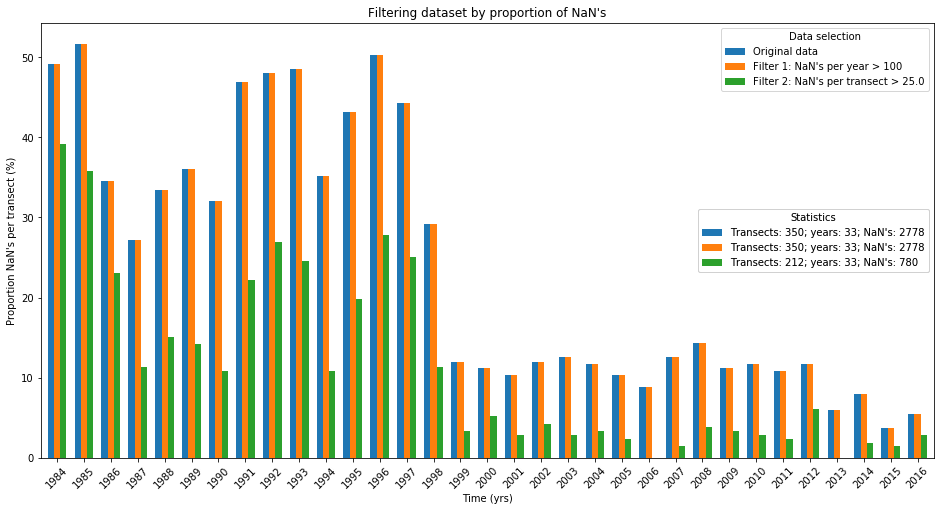

/media/storage/dev/shorelineforecasting/shorelineforecasting/visualization/plots.py:61: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  res = pd.concat([res, temp])


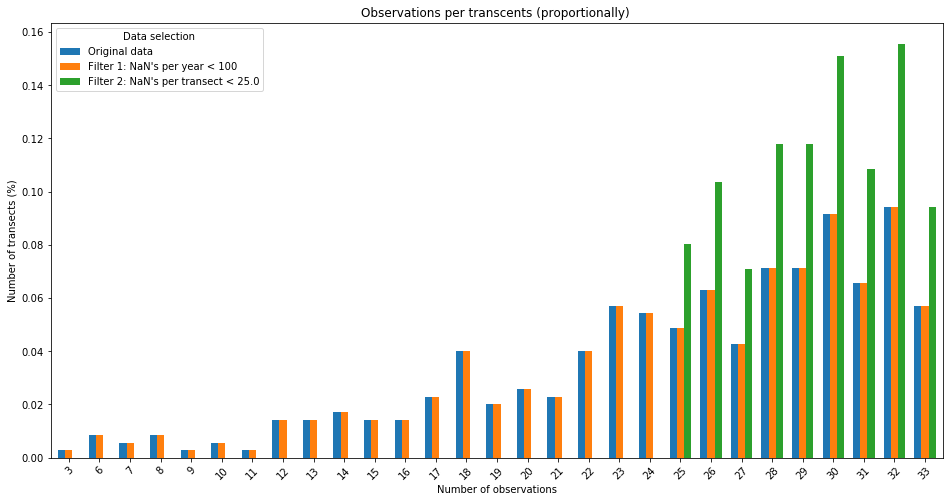

Saving results as: output/preprocessed/sample_1598919739.pkl


In [13]:
tsdf, _, _ = filter_tsdf_by_nans(tsdf, configs)
tsdf = interpolate_nans(tsdf)
save_preprocessed_data(tsdf, metadata, configs)

## Forecasting
We now focus on forecasting. Here we only present a basic LSTM network. In the future shorelines application will also other algorithms be implemented. 

In [14]:
# Optionally directly load data when data preprocessed data has been saved.
# configs, tsdf, metadata = load_preprocessed_data(filename="sample_1598259358.pkl")

### PyTorch configurations
First we set the basic configurations of PyTorch, such as a random seed for reproducability. We further get the LSTM model configurations.  

In [15]:
configure_torch(seed=configs['run']['seed'])
model_configs = get_lstm_configs(tsdf, configs)

device is: cpu


### Split and 
We first divide the dataset into train, validation and test partitions. This data is scaled between 0 and 1. Please note that scaling is only performed after splitting the data into train and test partitions in order to avoid information leaking into the test set. The model will be trained on the training set. Then the hyperparameters will be optimized by evaluation on the validation set. Finally, the model performance will be evaluated on the test set. Later we have to re-scale the output values, so we also save the scaler. 

In [16]:
train, val, test, test_raw, test_scaler = get_scaled_splits(tsdf, ratio=model_configs['split_ratio'])

### Input preparation
PyTorch includes automatic gradient calculations. However, to use these the data should be hold in PyTorch Tensor's. We additionaly load the tensor's into PyTorch's dataloaders for practical purposes. The data in these dataloaders consists of 10 time series per batch. Furthermore we see that the data is now split into 24:9 proportion: the first 24 years will be used for training, while the 9 latest are used for evaluation. 

In [17]:
dataloaders = get_torch_dataloaders(train, val, test, train_window=model_configs['train_window'],
                                    batch_size=model_configs['batch_size'])


Dataloader: train shape: torch.Size([10, 24]), target shape: torch.Size([10, 9])


### RNN Model
Here we define a basic RNN network.

In [18]:
rnn = Net(model_configs['input_size'], model_configs['hidden_size'], model_configs['output_size'])
print(rnn)

Net(
  (rnn): LSTM(1, 64, batch_first=True)
  (out): Sequential(
    (0): Linear(in_features=64, out_features=9, bias=True)
  )
)


### Train loop
We train the model for 10 epochs. This is incredibly fast since we only used a small sample of the dataset.

In [19]:
train_model(rnn, dataloaders, model_configs)

Epoch 1 Train Loss:0.805628744875723, Val Loss:0.053383686314002296
Epoch 2 Train Loss:0.15113735734673278, Val Loss:0.004961638942554068
Epoch 3 Train Loss:0.08345966292032714, Val Loss:0.0017264972340933916
Epoch 4 Train Loss:0.062051243862422556, Val Loss:0.004966298590228254
Epoch 5 Train Loss:0.06747411548208938, Val Loss:0.0021802615317215762
Epoch 6 Train Loss:0.05217072429892515, Val Loss:0.005120873994675806
Epoch 7 Train Loss:0.07077028151100848, Val Loss:0.0100122451220673
Epoch 8 Train Loss:0.07982978556751599, Val Loss:0.005496784774619212
Epoch 9 Train Loss:0.06328280037083416, Val Loss:0.002574247255457778
Epoch 10 Train Loss:0.05776195710715191, Val Loss:0.00902170854441528
Finish training


### Inference
We now use the trained model for inference on the test partition. The overall performance is evaluated by several statistics. 

In [20]:
forecast = inference_model(rnn, dataloaders['test'], model_configs)
forecast = pt2df(forecast, model_configs, test, inverse_scaling=True, test_scaler=test_scaler)
performance = forecast.apply(lambda x: evaluate_performance(test_raw[x.name], x, model_configs),
                                       result_type="expand").T
performance.columns = model_configs['evaluation']
performance

,mse,mae,mape,rmse,umbrae
transect_id,,,,,
BOX_187_211_211,161.757010,9.526515,0.017270,12.718373,0.824887
BOX_167_036_51,2015.985496,41.936925,0.047016,44.899727,2.855507
BOX_183_523_442,745.068337,25.533524,0.030646,27.295940,2.333400
BOX_208_146_208,279.405686,14.780501,0.031877,16.715433,1.713846
BOX_123_133_113,1820.906290,41.966985,0.042082,42.672079,5.038899
BOX_106_212_26,871.817965,26.900146,0.026815,29.526564,4.946185
BOX_149_291_324,2180.678586,45.922702,0.048211,46.697736,5.788070
BOX_105_006_13,5388.884583,73.333652,0.060669,73.409022,30.540126
BOX_183_512_122,1881.584568,39.368624,0.042668,43.377236,1.281415


### Show a forecast example. 

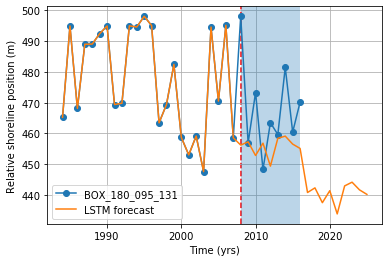

In [21]:
plot_forecast(test_raw, forecast, configs, model_configs, transect_id=model_configs['transect_id'])

### Save the results 

In [22]:
print(f"\n Performance LSTM: \n{performance.mean()}")
timestamp = int(datetime.timestamp(datetime.now()))
forecast.to_csv(f"output/forecasts/lstm_{timestamp}.csv")


 Performance LSTM: 
mse       2136.955683
mae         35.800993
mape         0.042832
rmse        38.266170
umbrae       4.790390
dtype: float64
